# Predicting Consumption
In this example, we analyze some data downloaded from the [Federal Reserve Economic Data](https://fred.stlouisfed.org). In particular, we want to build a model to predict the [Real Personal Consumption Expenditures (PCECC96)](https://fred.stlouisfed.org/series/PCECC96) using four information:

* [Unemployment Rate (UNRATE)](https://fred.stlouisfed.org/series/UNRATE)
* [Industrial Production: Total index (IPB50001SQ)](https://fred.stlouisfed.org/series/IPB50001SQ)
* [Real Disposable Personal Income (DPIC96)](https://fred.stlouisfed.org/series/DPIC96)
* [Personal Saving (PSAVE)](https://fred.stlouisfed.org/series/PSAVE)

The example is inspired to Chapter 7 of the book [Forecasting: Principles and Practice](https://otexts.com/fpp2/) by Rob J Hyndman and George Athanasopoulos. We preprocessed the original data and saved them in a csv file. We renamed the columns to provide a simplified indication of the original information.

As usual, we start by loading the libraries and the data.

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# predefined figsize
figsize=(12,9)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
df = pd.read_csv('fred_data.csv', index_col='observation_date', parse_dates=['observation_date'])

In [3]:
df.head()

,unemployment,income,production,consumption,savings
observation_date,,,,,
1948-01-01,3.733333,1421.789,14.7233,1307.283,12.763
1948-04-01,3.666667,1465.890,14.8803,1322.494,16.672
1948-07-01,3.766667,1489.793,15.0187,1324.446,19.876
1948-10-01,3.833333,1498.173,14.8618,1335.016,19.458
1949-01-01,4.666667,1468.673,14.3818,1337.177,15.143


Let's plot the data.

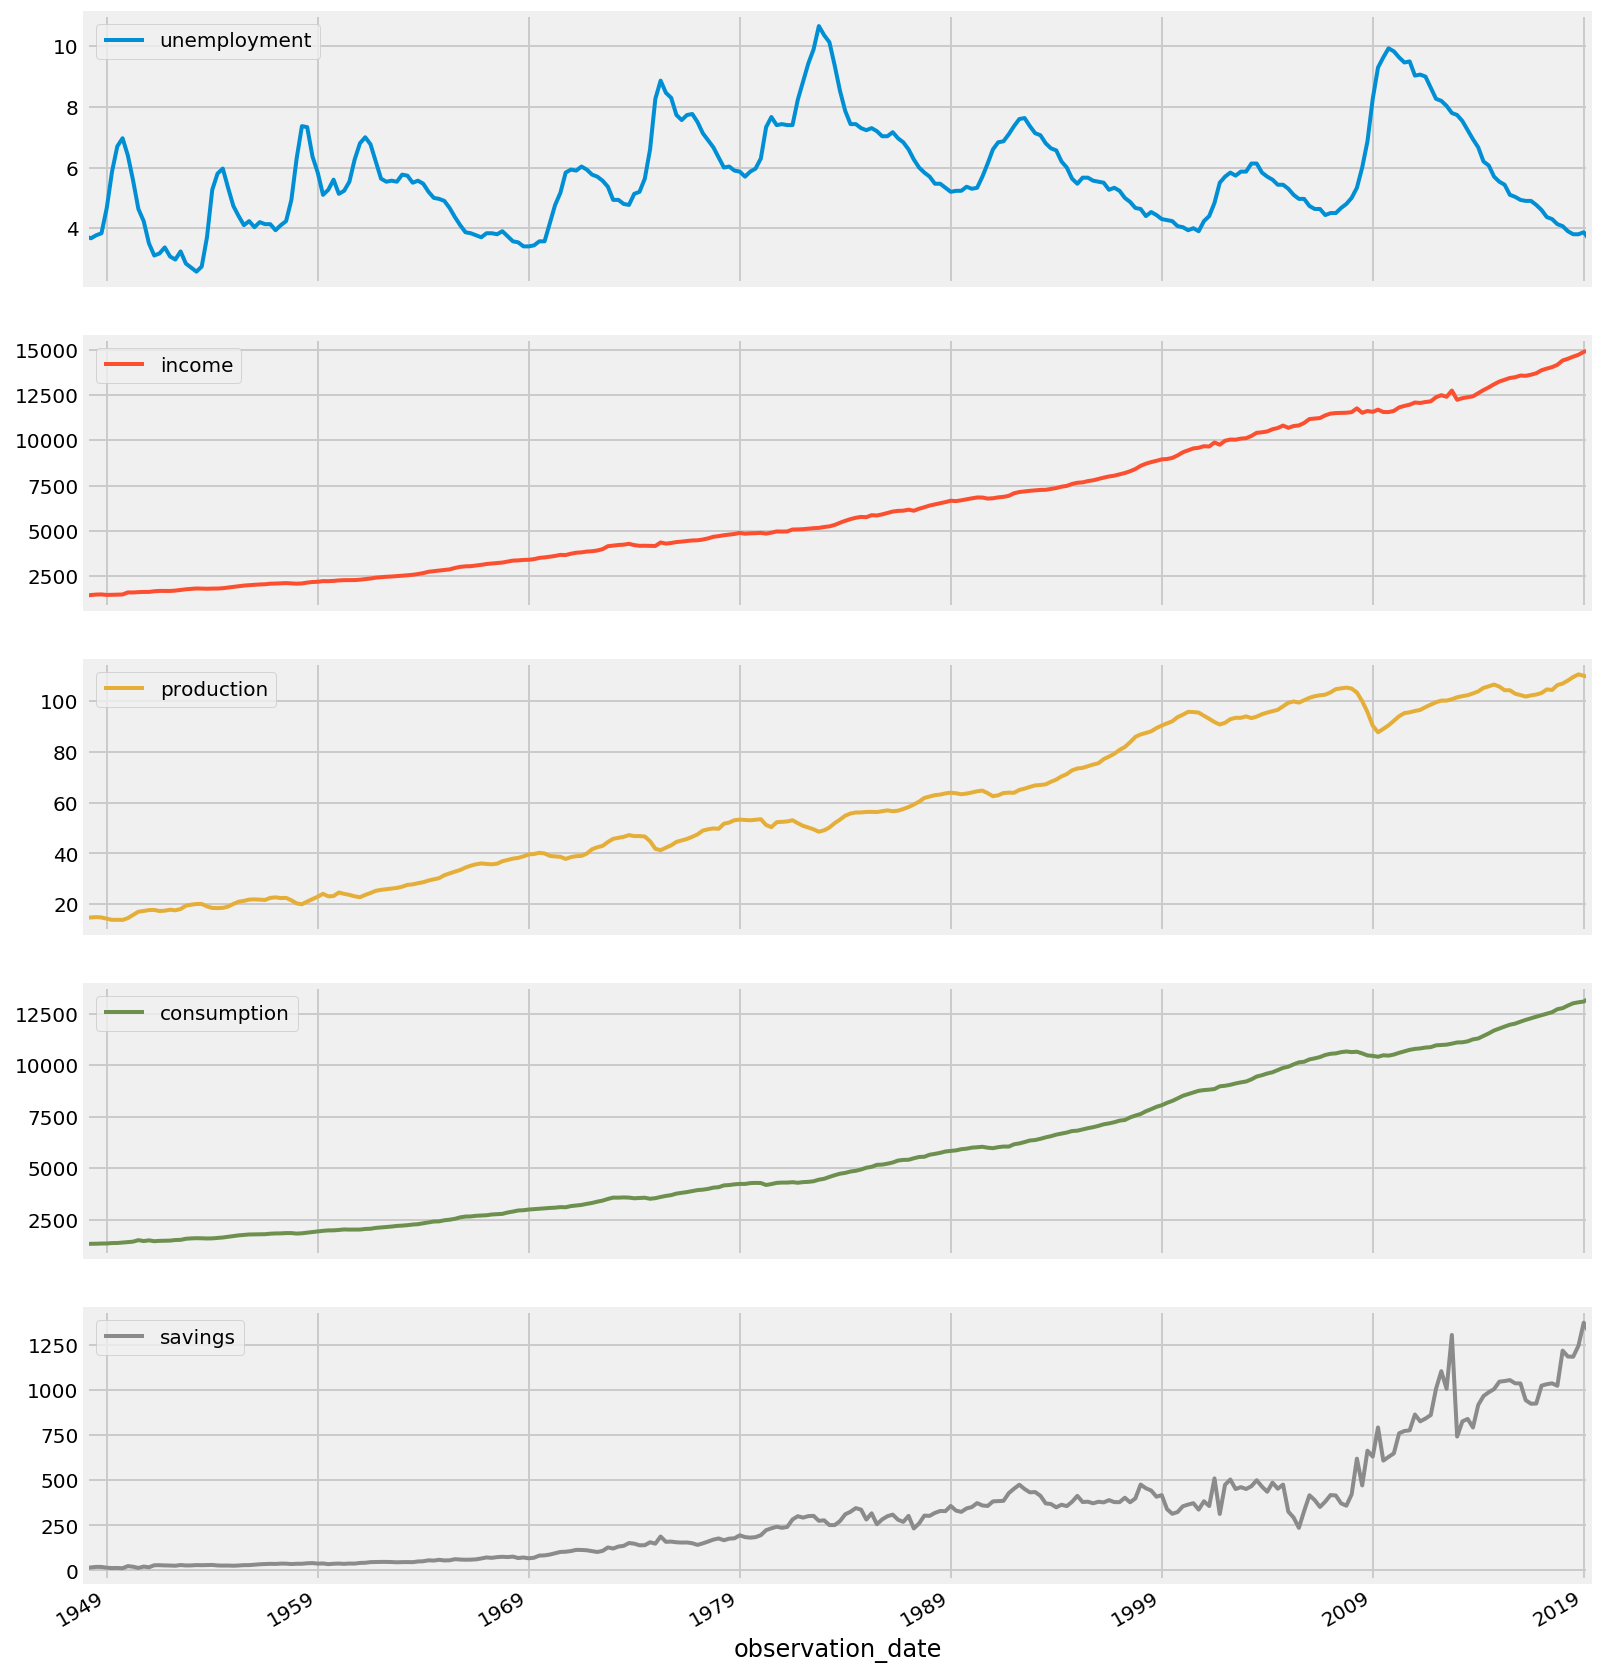

In [4]:
df.plot(subplots=True, figsize=(12,16));

We want to predict [Real Personal Consumption Expenditures (PCECC96)](https://fred.stlouisfed.org/series/PCECC96) in the recent years so it does not make sense to keep the data from 1950s. Thus, we focus on the data starting from 1980.

In [5]:
df = df['1980':]

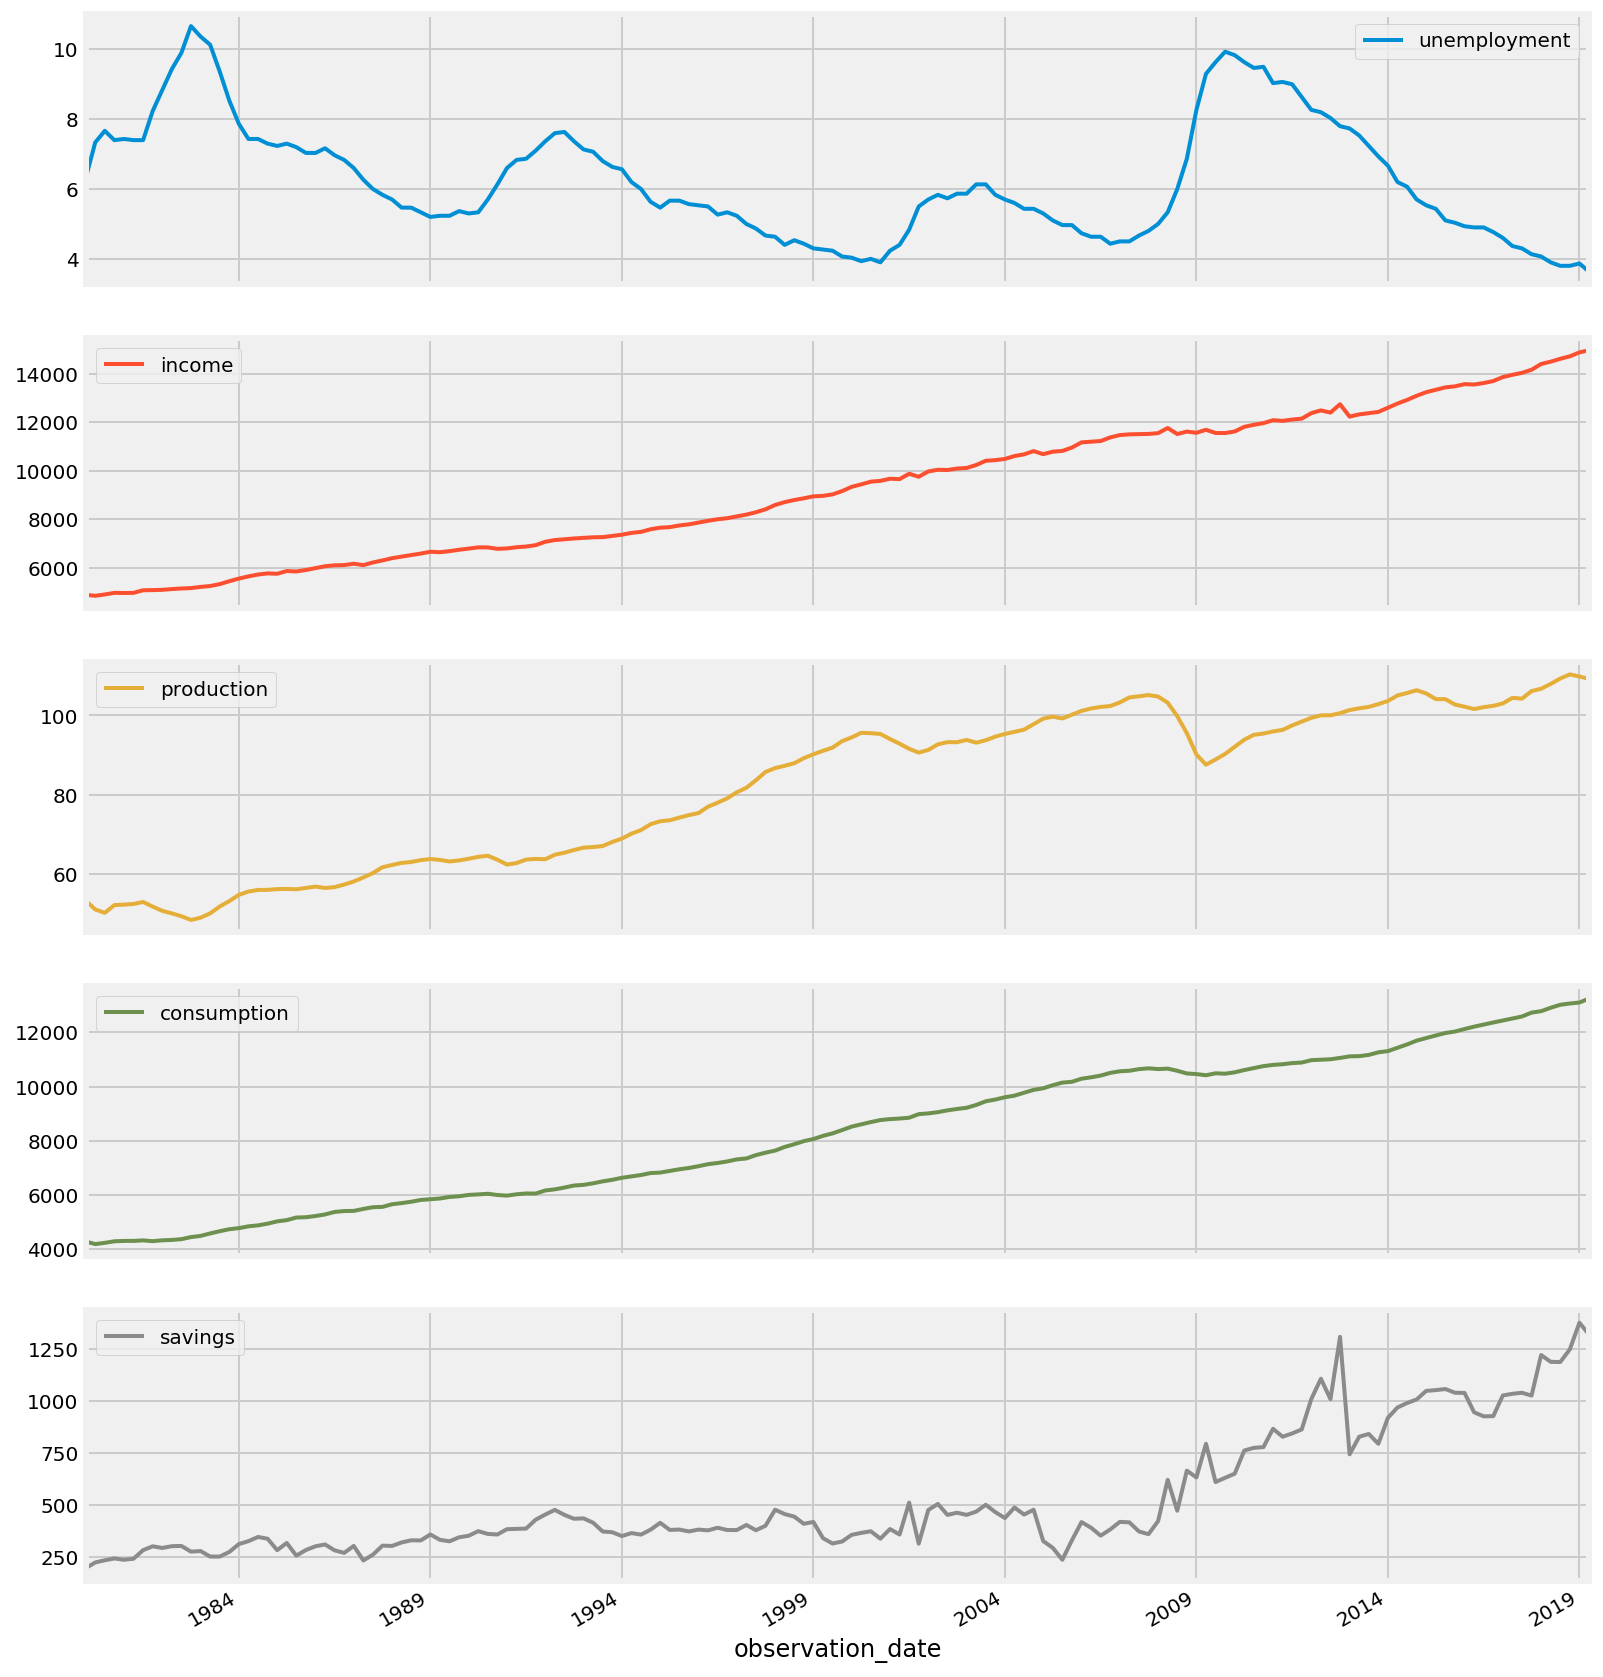

In [6]:
df.plot(subplots=True, figsize=(12,16));

## Stationarity
As already discussed, as the very first step we need to check whether our target series is stationary. For this purpose, we apply Augmented Dickey-Fuller test with a 95% (or 0.95) confidence level and check the returned p-value. If the p-value is less than 0.05 (that is 1-0.95) we can reject the null hypothesis that the data comes from a random walk; if the p-value is greater than 0.05 we cannot reject the null hypothesis that the data actually comes from a random walk, thus it is likely to be non-stationary and we need to transform it into a stationary series by applying the usual transformations.

In [7]:
p_value_consumption = adfuller(df['consumption'])
print("p-value: %.4f"%p_value_consumption[1])

p-value: 0.9875


We need to apply a transformation to the target variable to make it stationary. For instance, instead of using the actual value we can forecast its percentage change.

In [8]:
# let's copy the original data
df_change = df.copy()

# let's substitute the original consumption with *pct_change()*
df_change['consumption'] = df['consumption'].pct_change()
df_change.dropna(inplace=True)

# let' check the p-value
p_value_consumption = adfuller(df_change['consumption'])
print("p-value: %.4f"%p_value_consumption[1])

p-value: 0.0076


As can be noted, the simple transformation has made the series non-stationary. Since we are now tracking the percentage change of the original variable it might be a good idea also to 

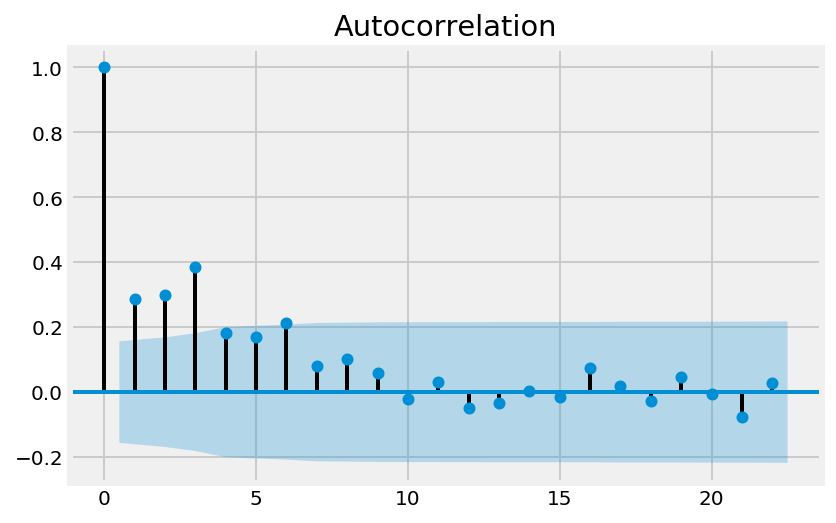

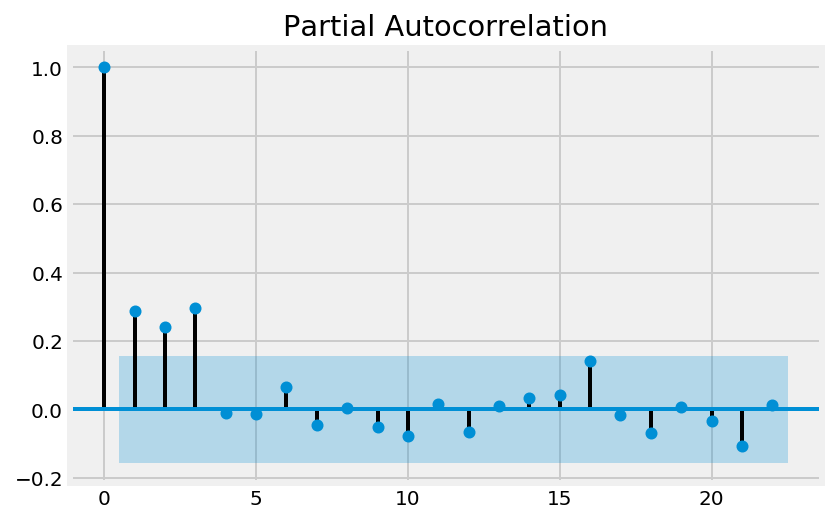

In [9]:
acf_consumption = plot_acf(df_change['consumption'])
acf_consumption = plot_pacf(df_change['consumption'])

Let's analyze the correlation among variables.

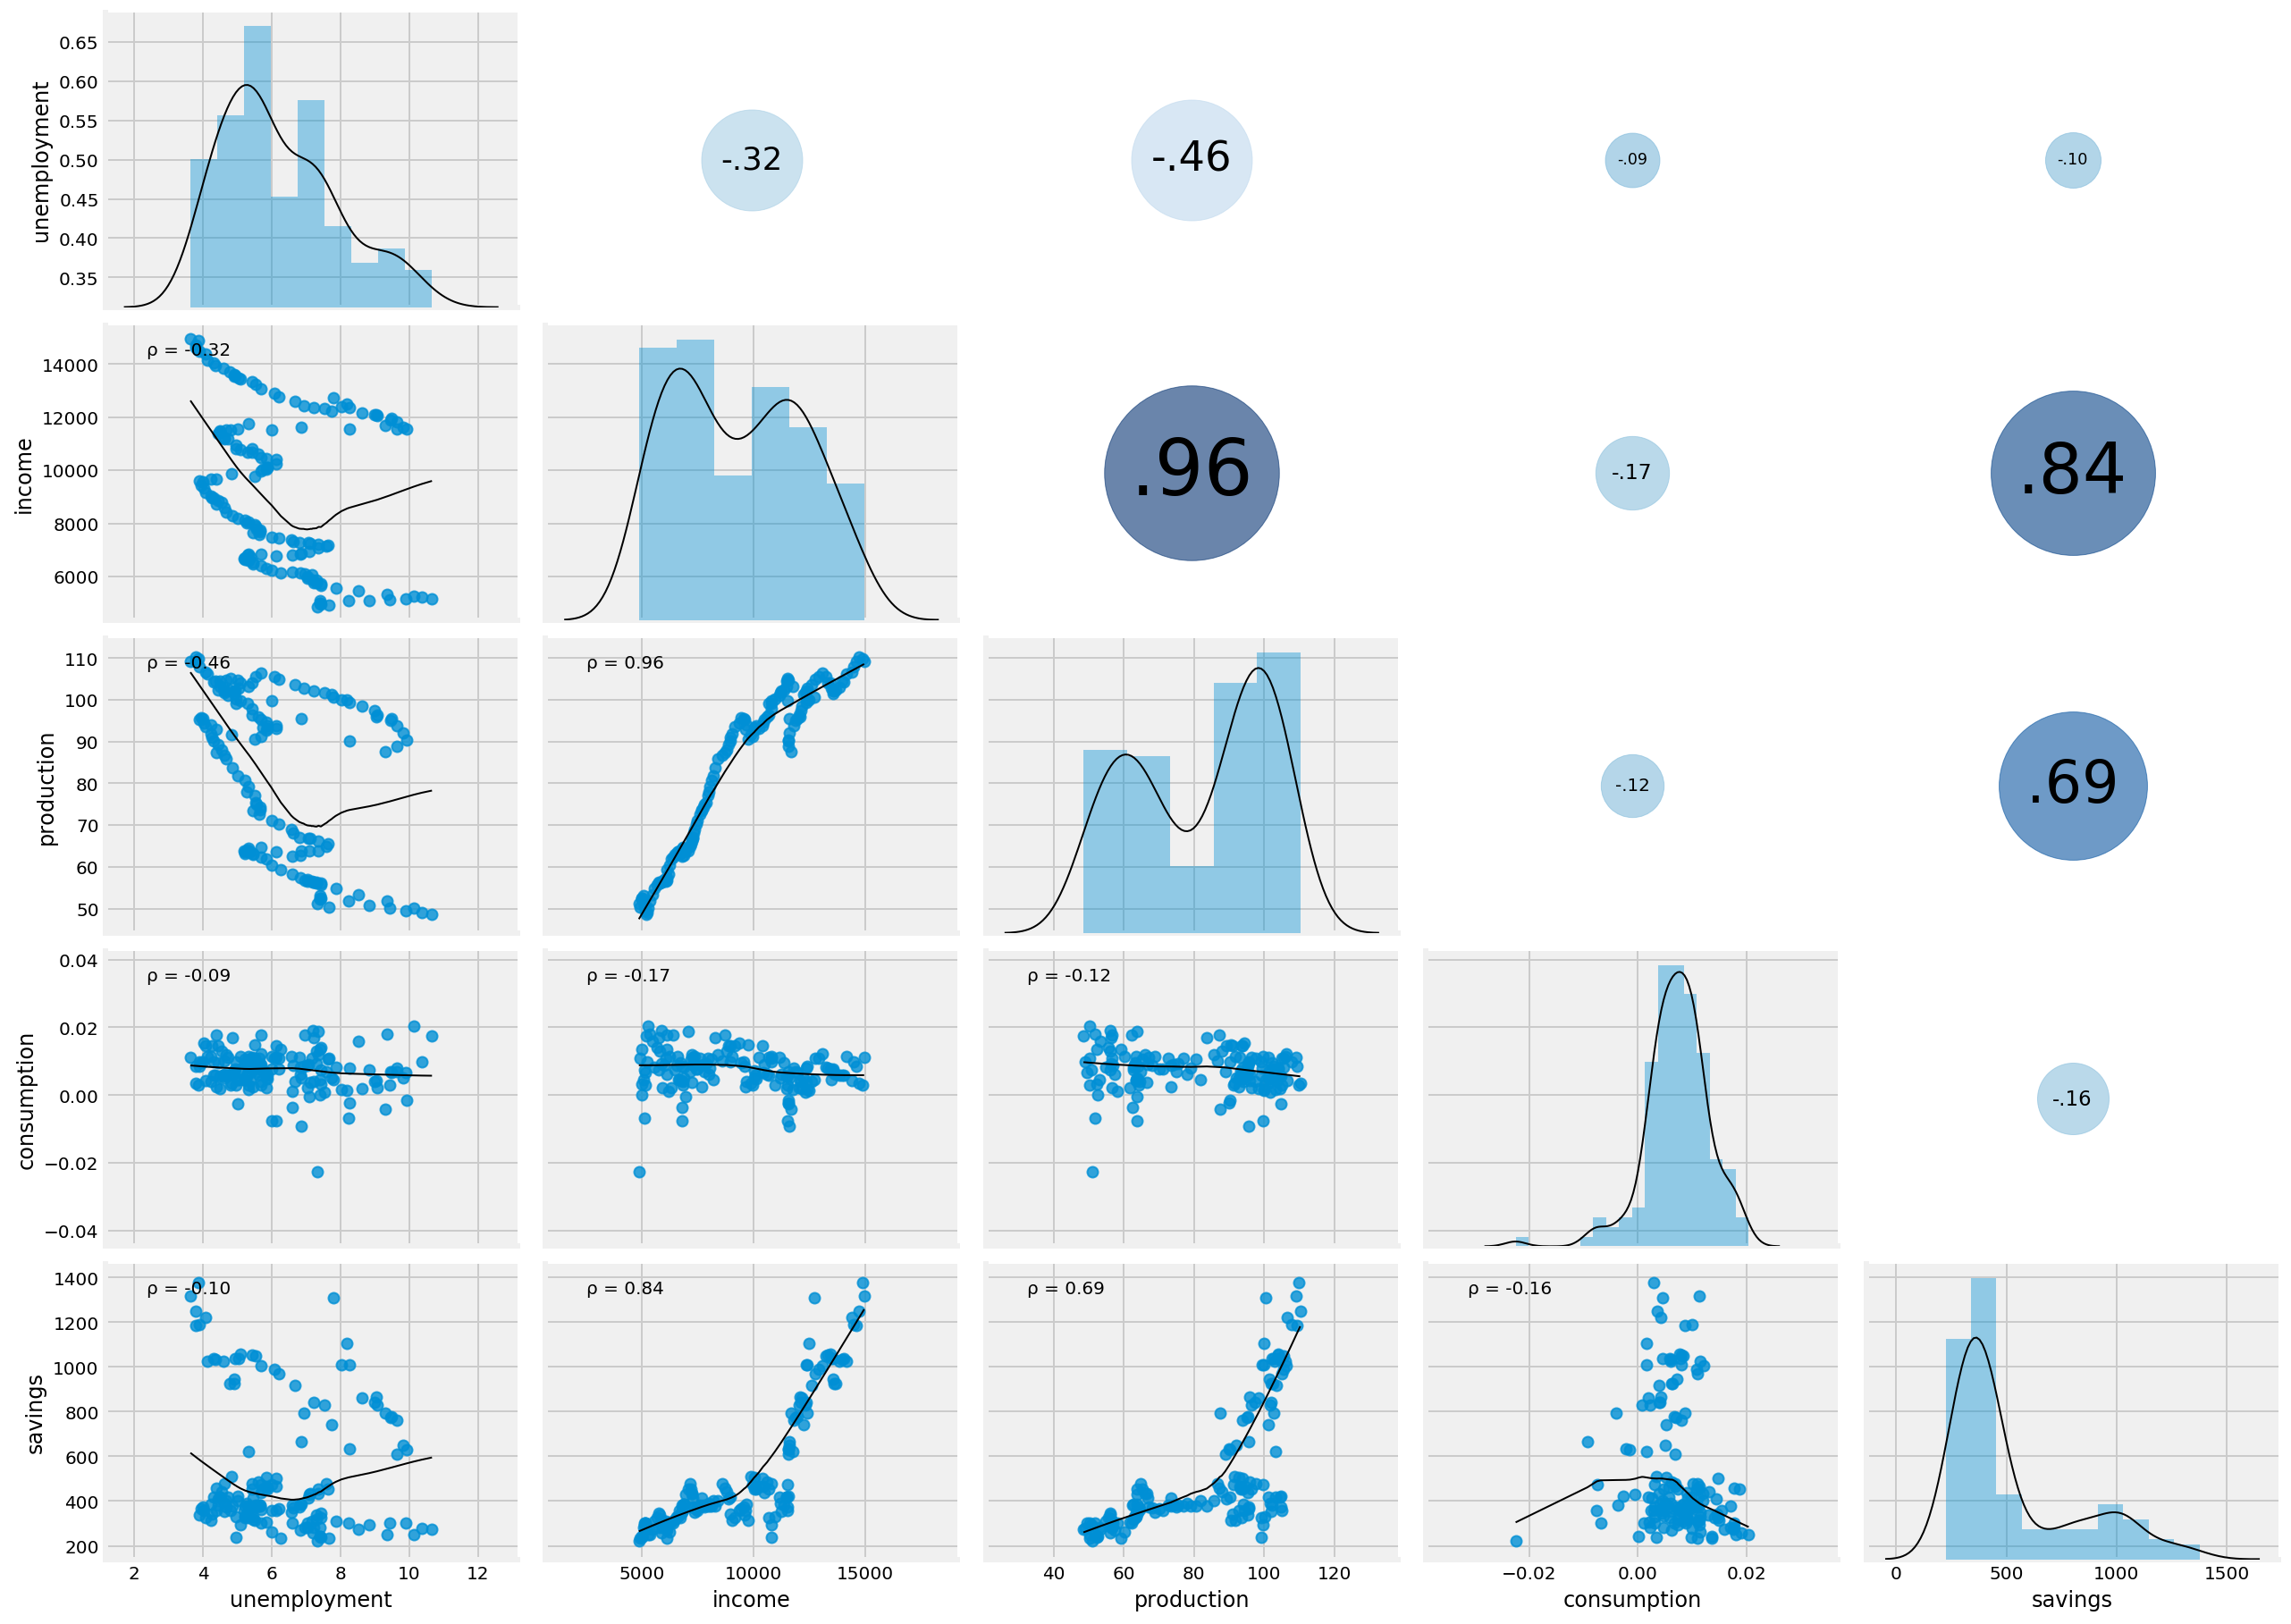

In [10]:
from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    
    
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(df_change, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

As we can note income and production are highly correlated as well as income and savings, which is reasonable to assume. Now let's define the input variables and the target variabale; then define the training and testing data; finally, we plot them two sets.

In [11]:
target_variable = 'consumption'
input_variables = df_change.columns[df_change.columns!=target_variable]

In [12]:
X = df_change[input_variables]
y = df_change[target_variable]

In [13]:
X_train, X_test = X[:-8], X[-8:]
y_train, y_test = y[:-8], y[-8:]

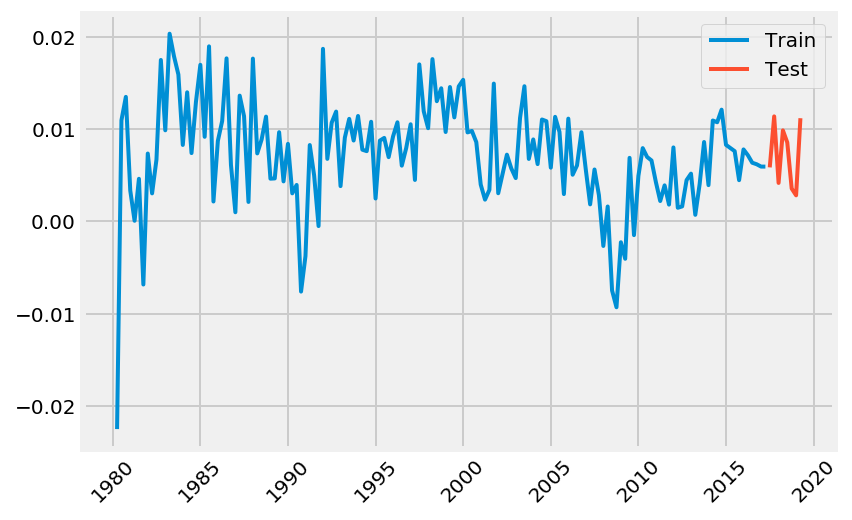

In [14]:
plt.plot(y_train,label='Train')
plt.plot(y_test,label='Test')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Linear Regression
We start by applying a simple linear regression to the raw data.

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.5f'%math.sqrt(mean_squared_error(yp, y_test)))

RMSE on Test 0.00448


In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test,yp))

MAPE on Test 48.014


In [18]:
df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

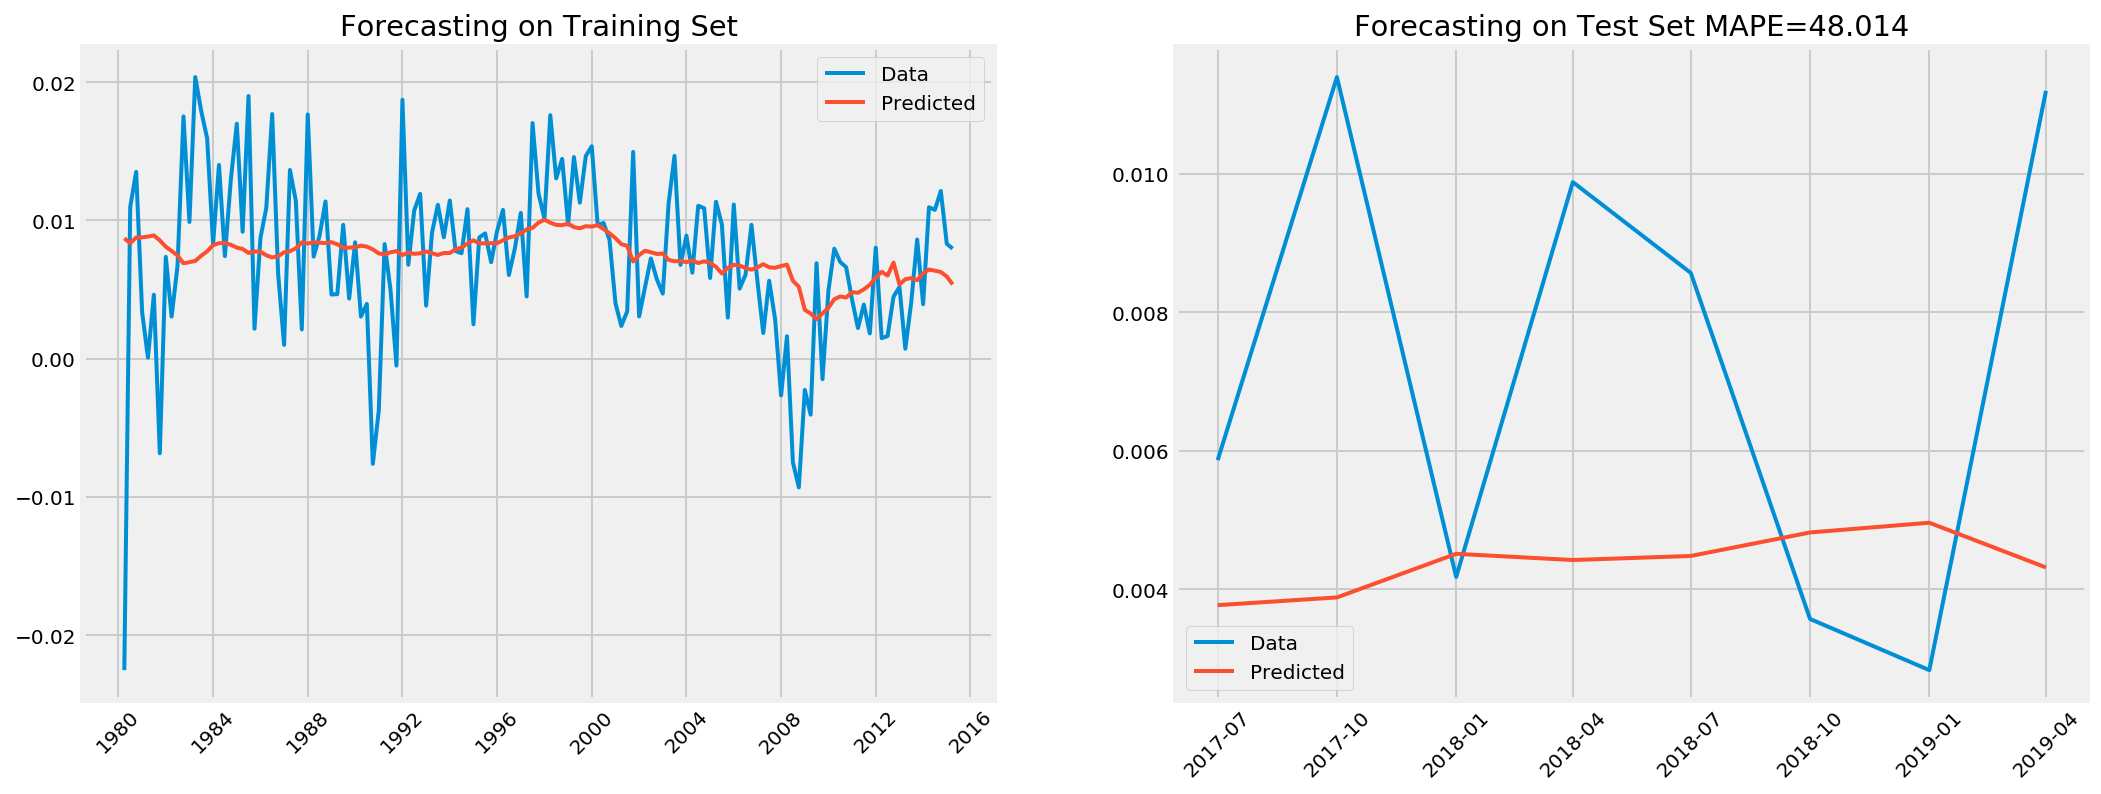

In [19]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['consumption'][:-8],label='Data')
plt.plot(df_result_train['predicted'][:-8],label='Predicted')
# plt.ylim([180,300])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['consumption'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')
# plt.ylim([200,330])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,yp))
plt.legend();

What if we add as an input also the consumption at time t-1? Let's see if this can improve the predictive power.

In [21]:
df_change['consumption-01'] = df_change['consumption'].shift()
df_change.dropna(inplace=True)

target_variable = 'consumption'
input_variables = df_change.columns[df_change.columns!=target_variable]

X = df_change[input_variables]
y = df_change[target_variable]

X_train, X_test = X[:-8], X[-8:]
y_train, y_test = y[:-8], y[-8:]

lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.5f'%math.sqrt(mean_squared_error(yp,y_test)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test,yp))

RMSE on Test 0.00471
MAPE on Test 48.220


It does not really improve the performance. So what if we add to the inputs also the percentage change of the original input variables? And for each input variable also its value at t-1?

In [22]:
# let's copy the original data
df_change = df.copy()

# let's substitute the original consumption with *pct_change()*
df_change['consumption'] = df['consumption'].pct_change()

target_variable = 'consumption'
input_variables = df_change.columns[df_change.columns!=target_variable]

# add the % change also for the other variables
for var in input_variables:
    df_change[var+'_change'] = df_change[var].pct_change()

# add t-1 for all the variables
input_variables = df_change.columns[df_change.columns!=target_variable]
for var in input_variables:
    df_change[var+'-01'] = df_change[var].shift()

df_change.dropna(inplace=True)

In [22]:
df_change

,unemployment,income,production,consumption,savings,unemployment_change,income_change,production_change,savings_change,unemployment-01,income-01,production-01,savings-01,unemployment_change-01,income_change-01,production_change-01,savings_change-01
observation_date,,,,,,,,,,,,,,,,,
1980-07-01,7.666667,4904.532,50.3368,0.010969,234.053,4.545455e-02,0.011232,-0.016425,0.046599,7.333333,4850.055,51.1774,223.632,0.164021,-0.008791,-0.042448,0.142308
1980-10-01,7.400000,4972.057,52.2738,0.013511,242.873,-3.478261e-02,0.013768,0.038481,0.037684,7.666667,4904.532,50.3368,234.053,0.045455,0.011232,-0.016425,0.046599
1981-01-01,7.433333,4965.100,52.3984,0.003350,236.564,4.504505e-03,-0.001399,0.002384,-0.025977,7.400000,4972.057,52.2738,242.873,-0.034783,0.013768,0.038481,0.037684
1981-04-01,7.400000,4970.894,52.5593,0.000073,241.431,-4.484305e-03,0.001167,0.003071,0.020574,7.433333,4965.100,52.3984,236.564,0.004505,-0.001399,0.002384,-0.025977
1981-07-01,7.400000,5078.088,53.0648,0.004626,282.647,4.440892e-16,0.021564,0.009618,0.170715,7.400000,4970.894,52.5593,241.431,-0.004484,0.001167,0.003071,0.020574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,3.900000,14495.935,107.9190,0.009880,1187.399,-4.098361e-02,0.006640,0.011237,-0.026872,4.066667,14400.314,106.7198,1220.188,-0.016129,0.016797,0.005660,0.190240
2018-07-01,3.800000,14613.284,109.2838,0.008568,1186.382,-2.564103e-02,0.008095,0.012647,-0.000856,3.900000,14495.935,107.9190,1187.399,-0.040984,0.006640,0.011237,-0.026872
2018-10-01,3.800000,14715.221,110.3249,0.003571,1247.600,0.000000e+00,0.006976,0.009527,0.051601,3.800000,14613.284,109.2838,1186.382,-0.025641,0.008095,0.012647,-0.000856


In [23]:
target_variable = 'consumption'
input_variables = df_change.columns[df_change.columns!=target_variable]

X=df_change[input_variables]
y=df_change[target_variable]

X_train, X_test = X[:-8], X[-8:]
y_train, y_test = y[:-8], y[-8:]

lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.5f'%math.sqrt(mean_squared_error(yp,y_test)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test,yp))

RMSE on Test 0.00275
MAPE on Test 51.980


As we can see it does not really improve performance.

In [24]:
df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

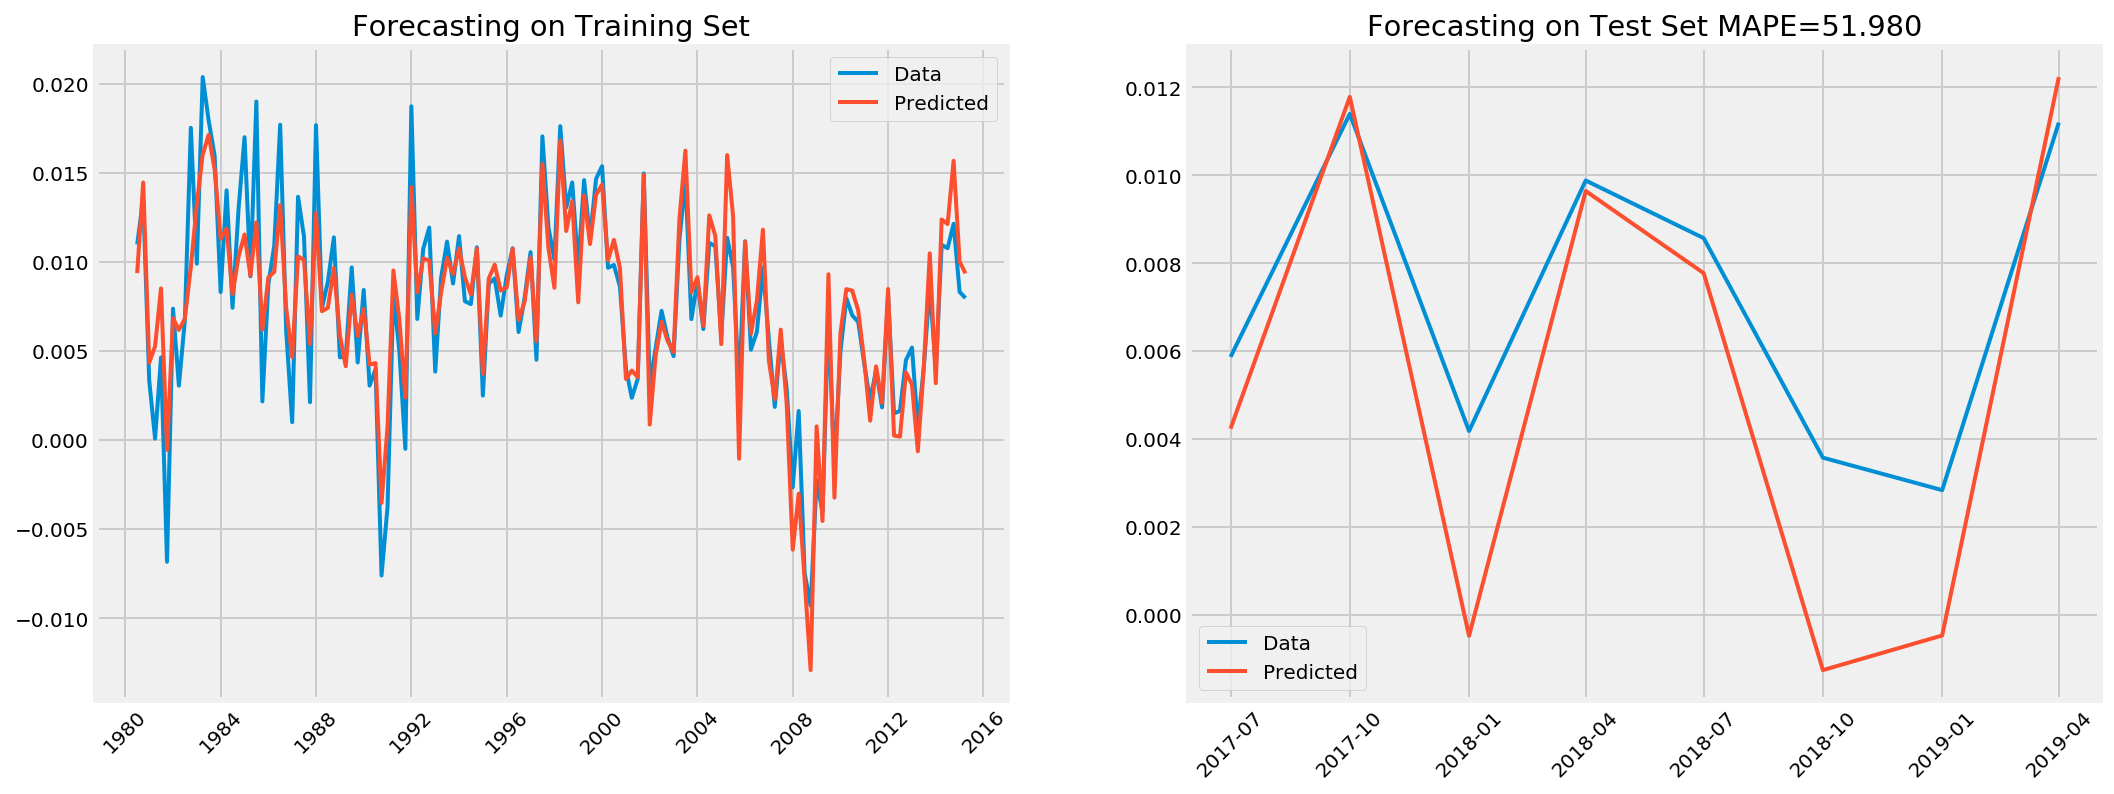

In [25]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['consumption'][:-8],label='Data')
plt.plot(df_result_train['predicted'][:-8],label='Predicted')
# plt.ylim([180,300])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['consumption'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')
# plt.ylim([200,330])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,yp))
plt.legend();

We can plot the model weights to analyze what variables have the most influence in the prediction. As we can see several variables contribute to the final model. 

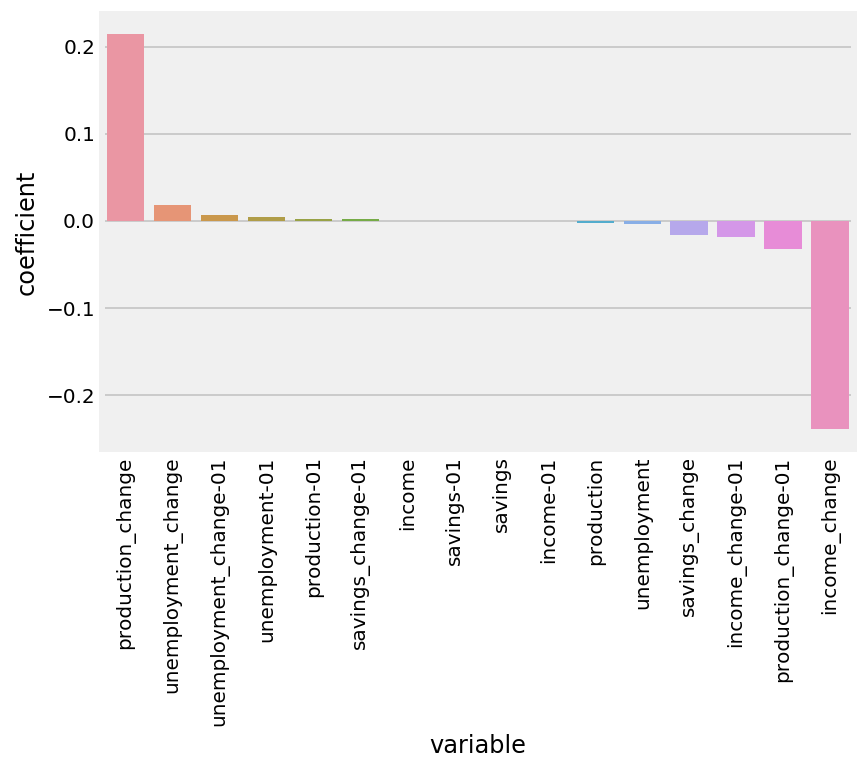

In [26]:
lr_coefficients = pd.DataFrame({'variable':X.columns, 'coefficient':lr_model.coef_}).sort_values(by=['coefficient'],ascending=False)
sns.barplot(x='variable',y='coefficient',data=lr_coefficients);
plt.xticks(rotation=90);

We want a simpler model so we apply Lasso that tends to zero-out useless variables.

In [27]:
lasso_model = Lasso(alpha=0.01,max_iter=1000)
lasso_model.fit(X_train,y_train)

yt = lasso_model.predict(X_train)
yp = lasso_model.predict(X_test)

print('RMSE on Test %.5f'%math.sqrt(mean_squared_error(yp,y_test)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test,yp))

RMSE on Test 0.00316
MAPE on Test 29.660


As we note the prediction is much better and also the number of variables contributing to the model is much fewer (see the weight plot below). Note that the performance improvement is also due to the choice of an adequate value of $\alpha$. If we repeat the experiment with an $\alpha$ of 1.0 the performance will worsen significantly.

In [28]:
df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

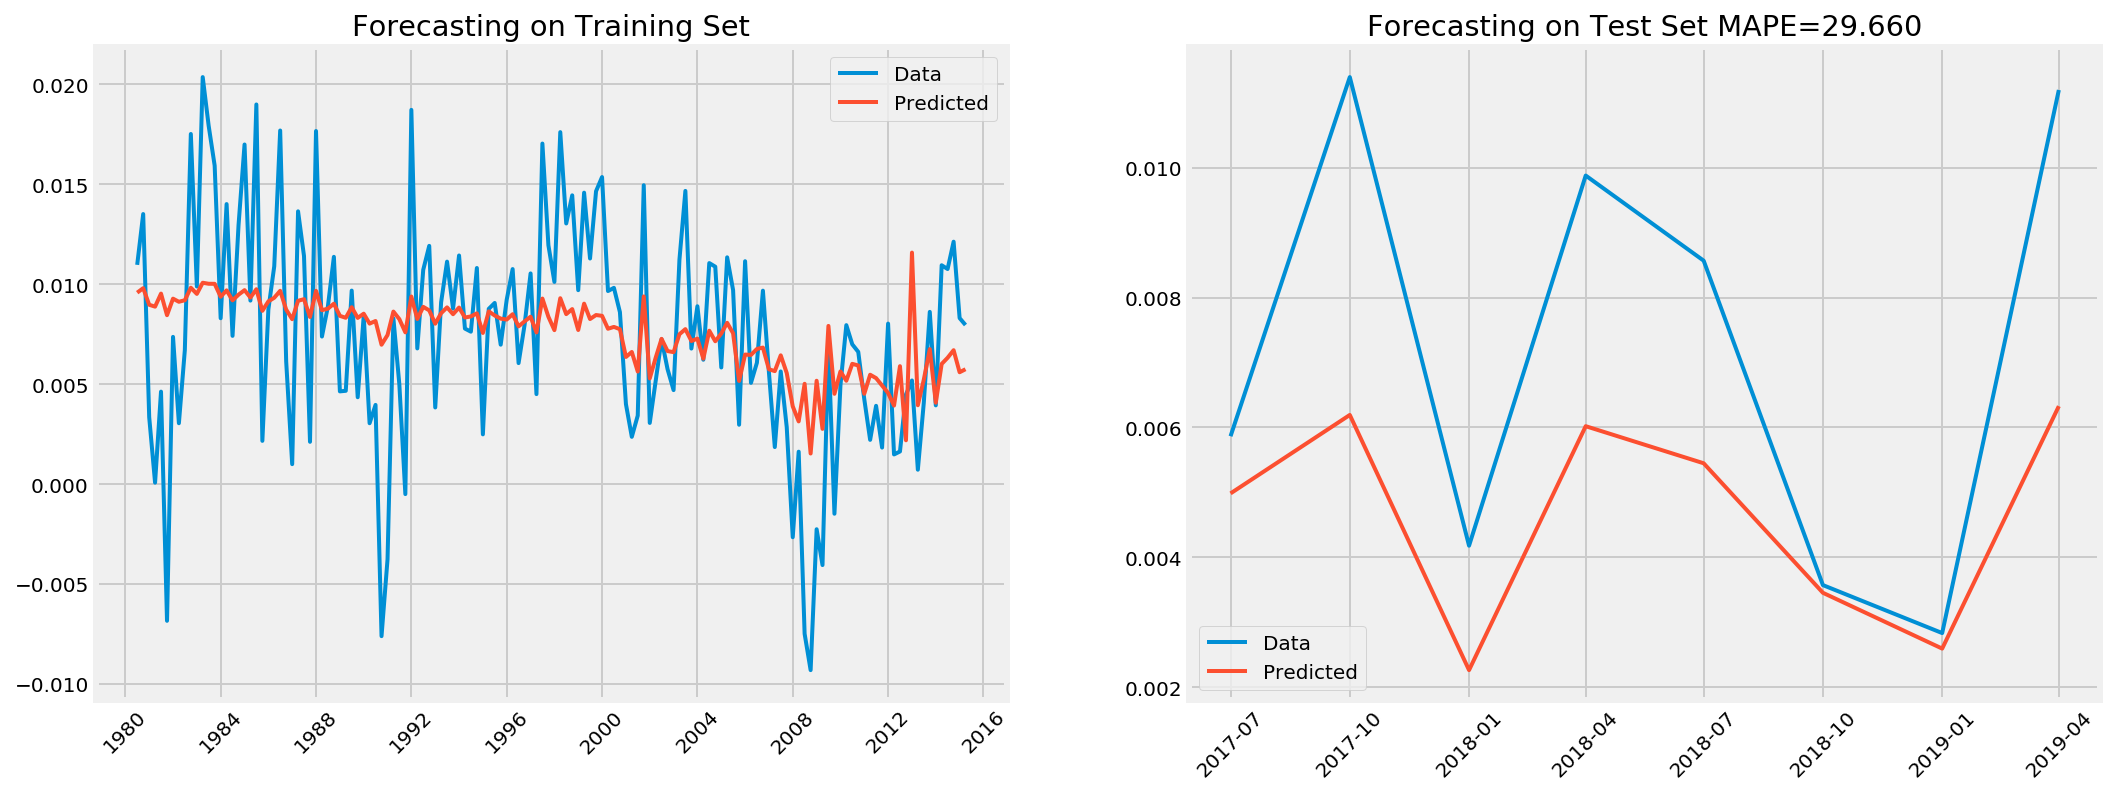

In [29]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['consumption'][:-8],label='Data')
plt.plot(df_result_train['predicted'][:-8],label='Predicted')
# plt.ylim([180,300])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['consumption'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')
# plt.ylim([200,330])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,yp))
plt.legend();

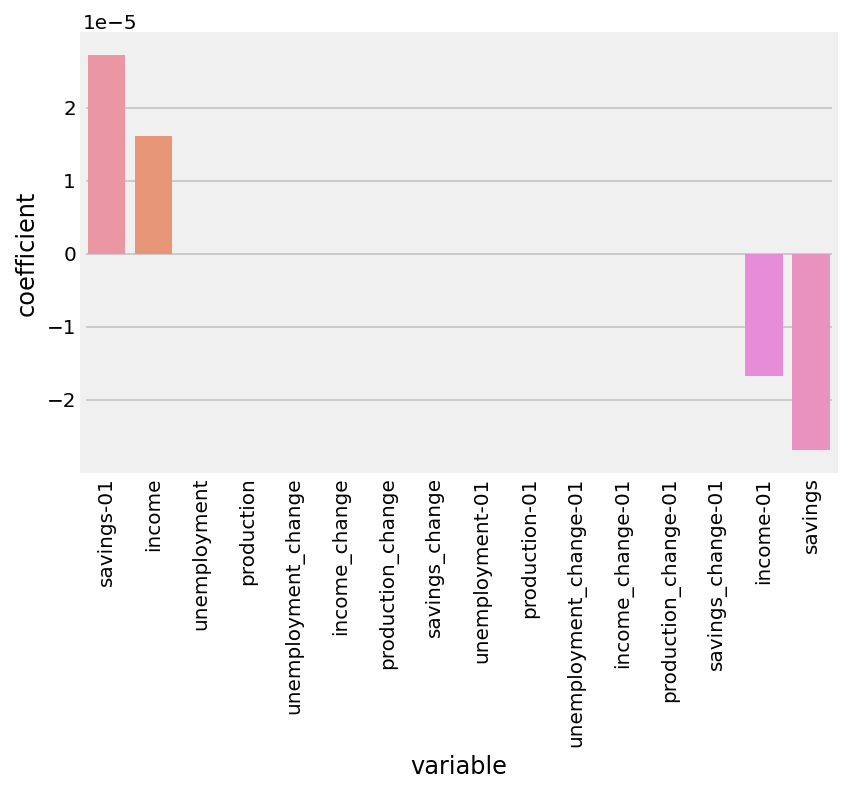

In [30]:
lasso_coefficients = pd.DataFrame({'variable':X.columns, 'coefficient':lasso_model.coef_}).sort_values(by=['coefficient'], ascending=False)
sns.barplot(x='variable', y='coefficient', data=lasso_coefficients);
plt.xticks(rotation=90);

## Random Forest Models
Let's apply random forest models and see whether they can improve the prediction.

In [30]:
forest = RandomForestRegressor(n_estimators=100, random_state=1)
forest.fit(X_train, y_train)

forest_yt = forest.predict(X_train)
forest_yp = forest.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(y_test, forest_yp)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test, forest_yp))

RMSE on Test 0.003
MAPE on Test 46.302


In [31]:
df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = forest_yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = forest_yp

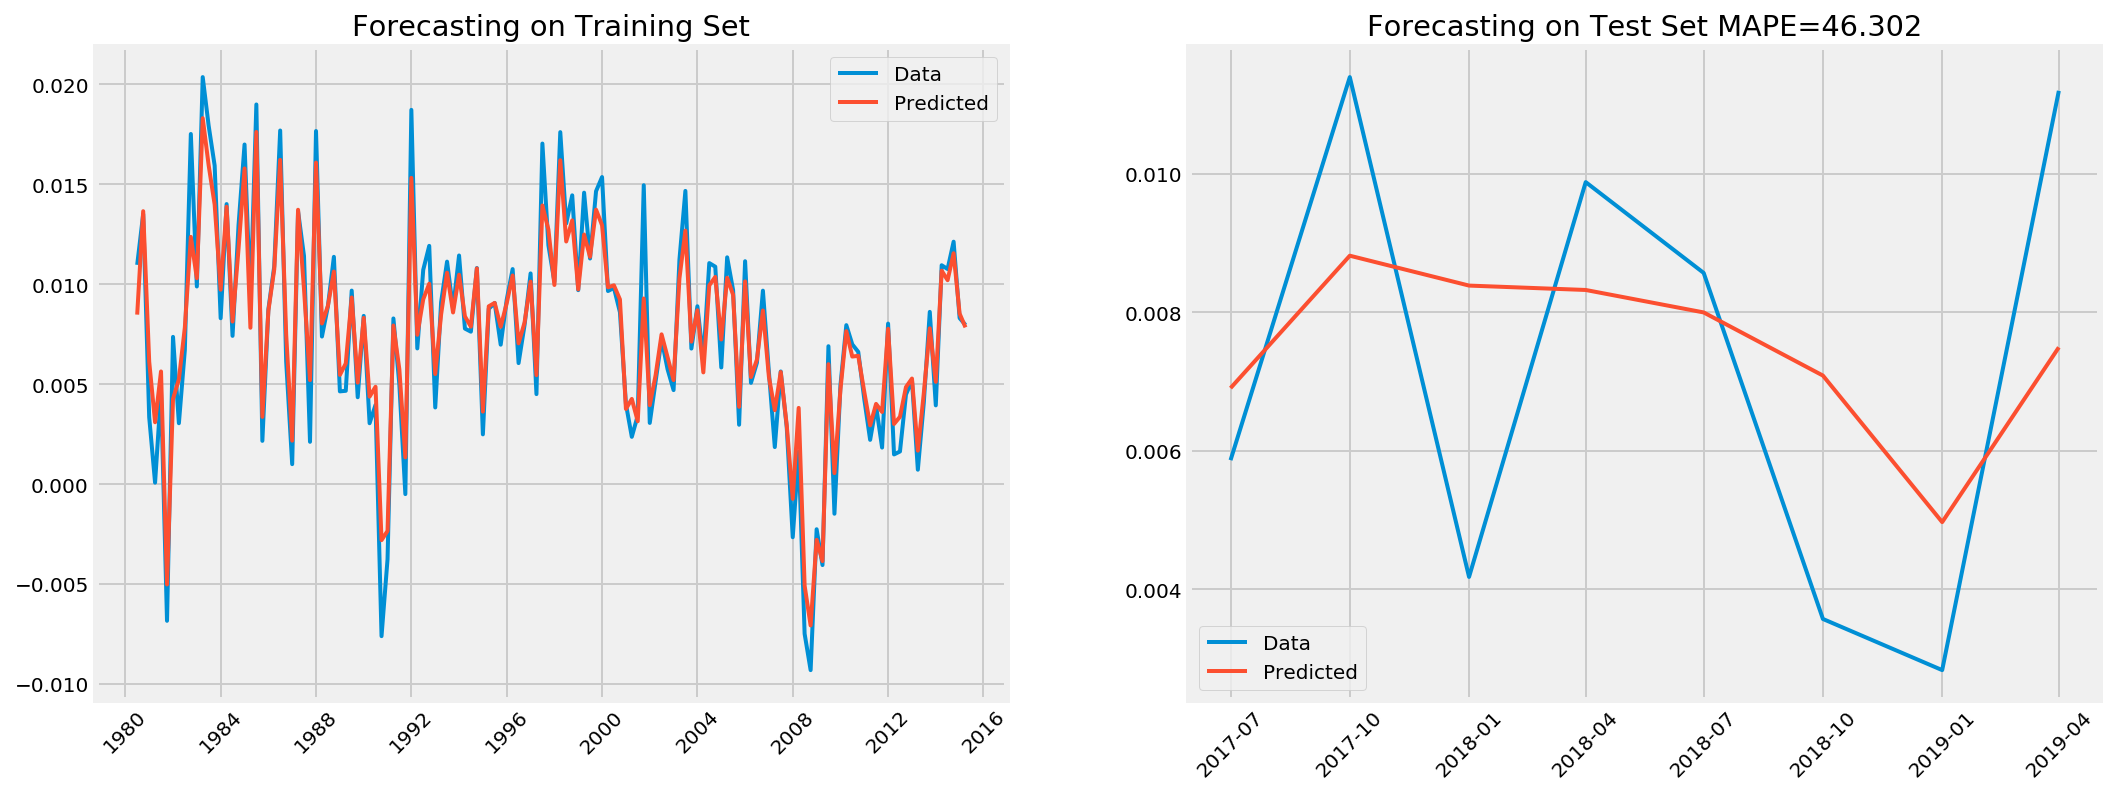

In [32]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['consumption'][:-8],label='Data')
plt.plot(df_result_train['predicted'][:-8],label='Predicted')
# plt.ylim([180,300])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['consumption'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')
# plt.ylim([200,330])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,forest_yp))
plt.legend();

Random forests as other ensemble methods produce an evaluation of feature importance which we can visualize.

In [33]:
def PlotRFFeatureImportance(forest,feature_names,sort_importance=True):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    if (sort_importance):
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.argsort(feature_names)[::-1]

    # Print the feature ranking
#     print("Feature ranking:")

#     for f in range(X.shape[1]):
#         print("%d. feature %d %s (%f)" % (f + 1, indices[f], feature_names[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), feature_names[indices],rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

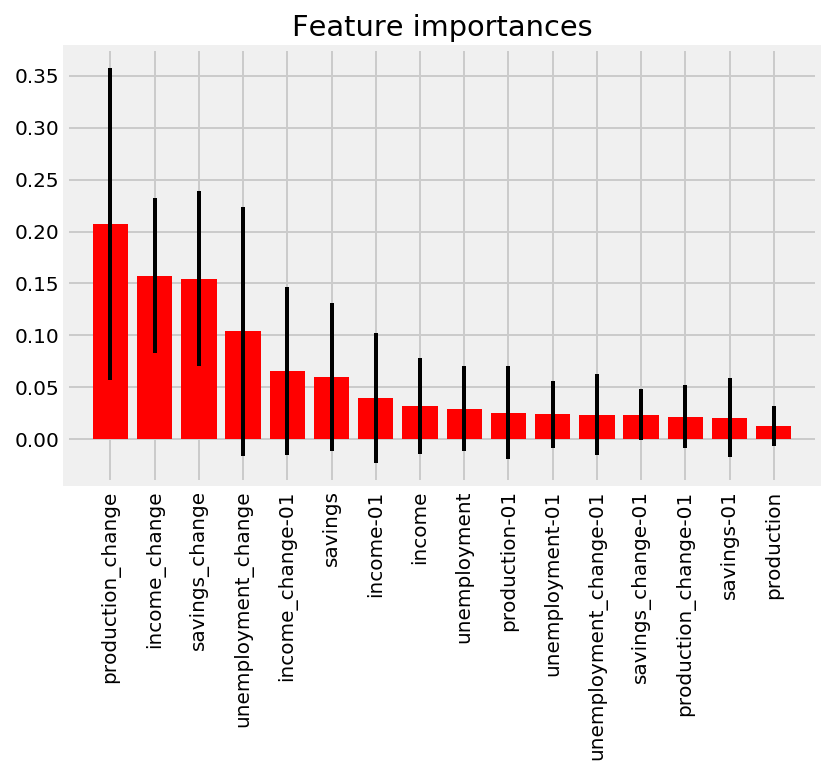

In [34]:
PlotRFFeatureImportance(forest,input_variables,True)

In [35]:
etr = ExtraTreesRegressor(n_estimators=100, random_state=1)
etr.fit(X_train, y_train)

etr_yt = etr.predict(X_train)
etr_yp = etr.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(y_test,etr_yp)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test,etr_yp))


RMSE on Test 0.003
MAPE on Test 54.715


## What Next?
There are several other approaches we can try to improve our model, for example we might
* add new t-k variables
* add rolling windows
* ...